In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [5]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [6]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [7]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        small_kernel_size = 3  
        big_kernel_size = 5
        
        self.decomposition1 = series_decomp(small_kernel_size)
        self.decomposition2 = series_decomp(big_kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
       
        # 현재는 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
        self.Linear_Seasonal = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init1,trend_init1 = self.decomposition1(x)
        seasonal_init2,trend_init2 = self.decomposition2(x)
        seasonal_init,trend_init = torch.cat([seasonal_init1,seasonal_init2],
                                             dim=2).to(self.device),torch.cat([trend_init1,
                                                                               trend_init2],dim=2).to(self.device)        
        seasonal_output = self.Linear_Seasonal(seasonal_init)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [8]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [9]:
torch.manual_seed(42)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_614235/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 2.9224122709959572 %
smape 2.0874924299835462 %
smape 1.2244685738529923 %
smape 0.4175627702416182 %
smape 0.12365828198789243 %
smape 0.10691512157706194 %
smape 0.09068637712564516 %
smape 0.07918660508023509 %
smape 0.07154992269964791 %
smape 0.06599545195101003 %
smape 0.062207623588449557 %
smape 0.058952798928700555 %
smape 0.056601816504766166 %
smape 0.054833424158975734 %
smape 0.053806097569401586 %
smape 0.05309212054888451 %
smape 0.052343723767543246 %
smape 0.051791234978757886 %
smape 0.05121076484149518 %
smape 0.050966393432991135 %
smape 0.05009732962696954 %
smape 0.05014241810401967 %
smape 0.04942625270862328 %
smape 0.049622301539890896 %
smape 0.05014856371311035 %
smape 0.04884190208446071 %
smape 0.04901775922108855 %
smape 0.0487661504081848 %
smape 0.04822709336648804 %
smape 0.04845976226858261 %
smape 0.04980034239648716 %
smape 0.04810543247493125 %
smape 0.04794814355490316 %
smape 0.04852895897252169 %
smape 0.04854575148783624 %
smape 0.04843686

In [14]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.0054160080355245555 %
SMAPE 0.010292978346669202 %
SMAPE 0.009672969598653935 %
SMAPE 0.0814497200381652 %
SMAPE 0.044457344550124844 %
SMAPE 0.08340723786523085 %
SMAPE 0.0037065958249797863 %
SMAPE 0.012353266794434603 %
SMAPE 0.012715977738025686 %
SMAPE 0.0031215397413575374 %
SMAPE 0.0008699713952040611 %
SMAPE 0.017975372637160092 %
SMAPE 0.028925042912774757 %
SMAPE 0.009897033257857402 %
SMAPE 0.03151915857557697 %
SMAPE 0.008857670976880172 %
SMAPE 0.012961650823072546 %
SMAPE 0.008043860255220636 %
SMAPE 0.008793121721438979 %
SMAPE 0.012664714137144983 %
SMAPE 0.030386937693492655 %
SMAPE 0.03036516243287224 %
SMAPE 0.004692295826103532 %
SMAPE 0.0015884910034174027 %
SMAPE 0.04673589527236288 %
SMAPE 0.051129068495129104 %
SMAPE 0.013052142161093627 %
SMAPE 0.005640968067353924 %
SMAPE 0.04291276053891124 %
SMAPE 0.014415782088065043 %
SMAPE 0.02161550939058543 %
SMAPE 0.020879039042370096 %
SMAPE 0.027543594430369467 %
SMAPE 0.046599970434556326 %
SMAPE 0.022725189

SMAPE 0.004014539972587272 %
SMAPE 0.0044032780832949925 %
SMAPE 0.014902873290736807 %
SMAPE 0.00937794236085665 %
SMAPE 0.007067775686408595 %
SMAPE 0.0016503081239989115 %
SMAPE 0.008389749281974446 %
SMAPE 0.027220025355063626 %
SMAPE 0.0074001615911925 %
SMAPE 0.005244831259147986 %
SMAPE 0.0036202207241302635 %
SMAPE 0.040898331571725066 %
SMAPE 0.004999024908386218 %
SMAPE 0.008194079057858517 %
SMAPE 0.001786589733598021 %
SMAPE 0.0019657146559097782 %
SMAPE 0.0053504061782518875 %
SMAPE 0.0018836845121370516 %
SMAPE 0.001907397110734621 %
SMAPE 0.0018052254697380479 %
SMAPE 0.006262617717794683 %
SMAPE 0.012007769383529876 %
SMAPE 0.0015771192609435045 %
SMAPE 0.0010548222425654785 %
SMAPE 0.006803769872661292 %
SMAPE 0.009208532929498858 %
SMAPE 0.006061451775451587 %
SMAPE 0.005487229259870219 %
SMAPE 0.012643479388799506 %
SMAPE 0.02796913652667854 %
SMAPE 0.005341683491622007 %
SMAPE 0.02135131416347491 %
SMAPE 0.009380860642863809 %
SMAPE 0.0014144248734595521 %
SMAPE 0.0

SMAPE 0.030512426732343556 %
SMAPE 0.037551934939614284 %
SMAPE 0.015111810923571056 %
SMAPE 0.008703537565565966 %
SMAPE 0.021918539240175505 %
SMAPE 0.04202566409918518 %
SMAPE 0.03395551865329338 %
SMAPE 0.006284876594349954 %
SMAPE 0.007659306745559035 %
SMAPE 0.003127181771844789 %
SMAPE 0.0015920009303727056 %
SMAPE 0.022932428816091033 %
SMAPE 0.022669254650509174 %
SMAPE 0.01864407862476014 %
SMAPE 0.0037128455589154896 %
SMAPE 0.011282456728395118 %
SMAPE 0.01532726793941208 %
SMAPE 0.008054889135735266 %
SMAPE 0.0024719915130617665 %
SMAPE 0.0007860309001443966 %
SMAPE 0.003806872260383898 %
SMAPE 0.011917716390883015 %
SMAPE 0.004909166242015317 %
SMAPE 0.005699695413312611 %
SMAPE 0.007660296291987834 %
SMAPE 0.00952531176528737 %
SMAPE 0.006394073949927303 %
SMAPE 0.005573658384491864 %
SMAPE 0.0030012122086873205 %
SMAPE 0.02199462876291136 %
SMAPE 0.002592968129995654 %
SMAPE 0.01919730750233839 %
SMAPE 0.00410156138306661 %
SMAPE 0.009259654048818788 %
SMAPE 0.002613874

SMAPE 0.047894523455909166 %
SMAPE 0.011771647288469467 %
SMAPE 0.022563101157061283 %
SMAPE 0.009162034086671156 %
SMAPE 0.014874418882641294 %
SMAPE 0.01430301280572621 %
SMAPE 0.0009689791633746836 %
SMAPE 0.004987575023989166 %
SMAPE 0.0015535546683054235 %
SMAPE 0.0009517868163015919 %
SMAPE 0.01736551753432991 %
SMAPE 0.0024359923035177644 %
SMAPE 0.010177293860380132 %
SMAPE 0.004267801595574383 %
SMAPE 0.010264399066429064 %
SMAPE 0.00677247454595431 %
SMAPE 0.020924979685389644 %
SMAPE 0.0038613547019110683 %
SMAPE 0.007947160453724678 %
SMAPE 0.014250254345242299 %
SMAPE 0.002158589381906495 %
SMAPE 0.013421246723908098 %
SMAPE 0.003984455203863035 %
SMAPE 0.023027891827325675 %
SMAPE 0.012997911959757857 %
SMAPE 0.015657827079394337 %
SMAPE 0.02354905984037714 %
SMAPE 0.002268352944916785 %
SMAPE 0.01191246225615572 %
SMAPE 0.0036919271197461967 %
SMAPE 0.0004377057230797731 %
SMAPE 0.012129941831133806 %
SMAPE 0.011797018771716239 %
SMAPE 0.05608199240614908 %
SMAPE 0.00261

SMAPE 0.039887934236134015 %
SMAPE 0.008095775145996242 %
SMAPE 0.0025622176705724087 %
SMAPE 0.0048073030086044355 %
SMAPE 0.0061555450380694765 %
SMAPE 0.016040170375845264 %
SMAPE 0.007107226278037615 %
SMAPE 0.003960542743769224 %
SMAPE 0.00905393582479519 %
SMAPE 0.005730855524006984 %
SMAPE 0.0062630959075704595 %
SMAPE 0.011905036726858498 %
SMAPE 0.005883530934944758 %
SMAPE 0.029490374397937558 %
SMAPE 0.002658326299751934 %
SMAPE 0.015635367241372933 %
SMAPE 0.011864769496753524 %
SMAPE 0.004396177513008581 %
SMAPE 0.0056212745393651176 %
SMAPE 0.004424394932627251 %
SMAPE 0.010430722786793467 %
SMAPE 0.003151106107679879 %
SMAPE 0.004800363461498591 %
SMAPE 0.007710223622211743 %
SMAPE 0.01791840778093956 %
SMAPE 0.004537243964421123 %
SMAPE 0.019091199809793125 %
SMAPE 0.004591121521116293 %
SMAPE 0.0019516753986863478 %
SMAPE 0.026940313414570483 %
SMAPE 0.010718815067434662 %
SMAPE 0.004177499497103554 %
SMAPE 0.007753501778950068 %
SMAPE 0.009915531996028903 %
SMAPE 0.00

SMAPE 0.002140458279654922 %
SMAPE 0.0018978949323553707 %
SMAPE 0.014649404258193499 %
SMAPE 0.002124172673646285 %
SMAPE 0.0025004946394631133 %
SMAPE 0.011435689874929267 %
SMAPE 0.0030581237070776983 %
SMAPE 0.002005333159658562 %
SMAPE 0.008135357009450672 %
SMAPE 0.001493934509284145 %
SMAPE 0.0036933901051838802 %
SMAPE 0.05402519261951966 %
SMAPE 0.009274384249863488 %
SMAPE 0.01551136564933131 %
SMAPE 0.00631981393098613 %
SMAPE 0.002575792374287289 %
SMAPE 0.004710635372006777 %
SMAPE 0.03015191118487337 %
SMAPE 0.020662474546412568 %
SMAPE 0.014488416058100029 %
SMAPE 0.0046466807983236436 %
SMAPE 0.02099187434396299 %
SMAPE 0.010912992879070771 %
SMAPE 0.005915337593592085 %
SMAPE 0.017235015253561414 %
SMAPE 0.00048231853816105286 %
SMAPE 0.009513765274299146 %
SMAPE 0.04704112067094002 %
SMAPE 0.004474752470969179 %
SMAPE 0.0014360680138523207 %
SMAPE 0.024288842835062496 %
SMAPE 0.004109001318624905 %
SMAPE 0.007217562913304221 %
SMAPE 0.0033219177132934874 %
SMAPE 0.019

SMAPE 0.04252016849017082 %
SMAPE 0.016302126056956467 %
SMAPE 0.0037816589891050967 %
SMAPE 0.0037959554420012864 %
SMAPE 0.0028148310577833513 %
SMAPE 0.02172231605629804 %
SMAPE 0.0007060755917223105 %
SMAPE 0.0037352973182578353 %
SMAPE 0.01076849922162637 %
SMAPE 0.0021455300332888783 %
SMAPE 0.008355695818607956 %
SMAPE 0.000925069408424406 %
SMAPE 0.007193226751724069 %
SMAPE 0.013271297321892916 %
SMAPE 0.003102003482354121 %
SMAPE 0.0026821742476101917 %
SMAPE 0.001329277281058694 %
SMAPE 0.006362367489373355 %
SMAPE 0.00543877532317083 %
SMAPE 0.0011880507521624395 %
SMAPE 0.0015072573231691422 %
SMAPE 0.007813860642869486 %
SMAPE 0.007787658581776213 %
SMAPE 0.004914787638924167 %
SMAPE 0.011527277302619154 %
SMAPE 0.014919750592532923 %
SMAPE 0.002797072724220584 %
SMAPE 0.010478592396736985 %
SMAPE 0.019049402359939904 %
SMAPE 0.005738252489322804 %
SMAPE 0.02907405042896016 %
SMAPE 0.00618564181283432 %
SMAPE 0.008183127948200308 %
SMAPE 0.025335834213933595 %
SMAPE 0.018

SMAPE 0.0024414499263869516 %
SMAPE 0.006554081586330085 %
SMAPE 0.001976512820192511 %
SMAPE 0.014800118260978934 %
SMAPE 0.0010412730597124664 %
SMAPE 0.004819193710034142 %
SMAPE 0.006841597010293299 %
SMAPE 0.01325153951896141 %
SMAPE 0.0024684045649436825 %
SMAPE 0.0026140089486261786 %
SMAPE 0.009993327737539914 %
SMAPE 0.001058396977839493 %
SMAPE 0.00798652761650942 %
SMAPE 0.0008009183814579045 %
SMAPE 0.036653878723626576 %
SMAPE 0.032508397537867495 %
SMAPE 0.004960492254980409 %
SMAPE 0.007798165419387716 %
SMAPE 0.0012136770596100632 %
SMAPE 0.009304954889799433 %
SMAPE 0.0018250378082029786 %
SMAPE 0.03971643228788935 %
SMAPE 0.02196461776838987 %
SMAPE 0.015619007307186903 %
SMAPE 0.005121033781982476 %
SMAPE 0.010429305568266045 %
SMAPE 0.004920284989552215 %
SMAPE 0.016150309220691383 %
SMAPE 0.0006615562268024178 %
SMAPE 0.011279556333334995 %
SMAPE 0.003267909337068886 %
SMAPE 0.001899958586761841 %
SMAPE 0.019135143013045308 %
SMAPE 0.02149822251053024 %
SMAPE 0.010

SMAPE 0.043060211173610696 %
SMAPE 0.0014211758520019657 %
SMAPE 0.007602166601827776 %
SMAPE 0.02912081316584647 %
SMAPE 0.01402127152800148 %
SMAPE 0.0009583657611500485 %
SMAPE 0.02852063633031321 %
SMAPE 0.040219727839293284 %
SMAPE 0.017445566084639097 %
SMAPE 0.01733690513760422 %
SMAPE 0.0038098657978764554 %
SMAPE 0.009469111177068612 %
SMAPE 0.009483130204841927 %
SMAPE 0.0062380687328271725 %
SMAPE 0.01868898156729415 %
SMAPE 0.009268223214689897 %
SMAPE 0.021131612793055865 %
SMAPE 0.010677918414330634 %
SMAPE 0.0021833816294858366 %
SMAPE 0.02129022841074857 %
SMAPE 0.024939957323226736 %
SMAPE 0.011325903213844413 %
SMAPE 0.01655584037526836 %
SMAPE 0.0048240108211246024 %
SMAPE 0.01436519314779616 %
SMAPE 0.0022715924239946617 %
SMAPE 0.022402970717735116 %
SMAPE 0.05634192574245845 %
SMAPE 0.007988310437269774 %
SMAPE 0.005602456747183737 %
SMAPE 0.016240857008185117 %
SMAPE 0.0063962449208929675 %
SMAPE 0.016891786403206765 %
SMAPE 0.005081043065054303 %
SMAPE 0.0026843

SMAPE 0.041626407429944834 %
SMAPE 0.014396289303562071 %
SMAPE 0.026432913731355256 %
SMAPE 0.02166065195260103 %
SMAPE 0.004096084722732485 %
SMAPE 0.0024510471095382513 %
SMAPE 0.014521043151830781 %
SMAPE 0.0014564026419066067 %
SMAPE 0.008503732699708166 %
SMAPE 0.02002251380326925 %
SMAPE 0.008356904221216155 %
SMAPE 0.01908693056347488 %
SMAPE 0.0004570655250972777 %
SMAPE 0.002806933968543035 %
SMAPE 0.0016702400306058962 %
SMAPE 0.005349363485663616 %
SMAPE 0.005275513138599308 %
SMAPE 0.01063209235154261 %
SMAPE 0.006733765764188604 %
SMAPE 0.006484107427944252 %
SMAPE 0.002520844817155421 %
SMAPE 0.026397243407359383 %
SMAPE 0.002097541752618781 %
SMAPE 0.013058638470440087 %
SMAPE 0.006313373753300765 %
SMAPE 0.0013557859283821472 %
SMAPE 0.017496139158566848 %
SMAPE 0.006916303286089941 %
SMAPE 0.02083728362234183 %
SMAPE 0.009878372084813236 %
SMAPE 0.01598516301022812 %
SMAPE 0.04988184410376562 %
SMAPE 0.00648577883818291 %
SMAPE 0.0421736459342128 %
SMAPE 0.00087286956

SMAPE 0.015549349441130289 %
SMAPE 0.014008601721116065 %
SMAPE 0.014490590248328772 %
SMAPE 8.141359865665436 %
SMAPE 10.913936231285334 %
SMAPE 0.36333411295618134 %
SMAPE 17.33470728993416 %
SMAPE 0.01590462161271944 %
SMAPE 0.23742615760397714 %
SMAPE 5.04760173894465 %
SMAPE 2.5154328970238566 %
SMAPE 2.811111087910831 %
SMAPE 3.7582764625549316 %
SMAPE 0.16721211501476319 %
SMAPE 0.8186971979230293 %
SMAPE 0.6328737031672063 %
SMAPE 0.009361126719596768 %
SMAPE 0.07164561231871858 %
SMAPE 0.01053229097340136 %
SMAPE 0.2507975337313155 %
SMAPE 0.011642650048884207 %
SMAPE 0.20723744251381504 %
SMAPE 0.705089725115613 %
SMAPE 0.03536240115860778 %
SMAPE 0.43548935814396833 %
SMAPE 0.2856609053264947 %
SMAPE 0.17141638326808106 %
SMAPE 0.05216017336078948 %
SMAPE 0.007802594473488967 %
SMAPE 0.396031339359979 %
SMAPE 0.6128566346114894 %
SMAPE 0.048945813053592246 %
SMAPE 0.045506048240383734 %
SMAPE 0.9278621351568291 %
SMAPE 0.02558913254898698 %
SMAPE 0.012065844302981077 %
SMAPE

SMAPE 0.11589671813089808 %
SMAPE 0.03018863232344415 %
SMAPE 0.032678100332645954 %
SMAPE 0.04350968964399726 %
SMAPE 0.004331024660771732 %
SMAPE 0.02235171602056596 %
SMAPE 0.02354012185139709 %
SMAPE 0.011913092554095783 %
SMAPE 0.03897330145781552 %
SMAPE 0.020466539687618024 %
SMAPE 0.013374450761290289 %
SMAPE 0.02444247813582479 %
SMAPE 0.016519347825806108 %
SMAPE 0.0032428886123057055 %
SMAPE 0.016711165010519835 %
SMAPE 0.005087681416242162 %
SMAPE 0.0020343080478539832 %
SMAPE 0.003694065482221731 %
SMAPE 0.013037884093364482 %
SMAPE 0.006987209835912722 %
SMAPE 0.0017839978597180561 %
SMAPE 0.005957678156107704 %
SMAPE 0.014630325931172194 %
SMAPE 0.009370944469836218 %
SMAPE 0.009759284264703183 %
SMAPE 0.0069198628090703105 %
SMAPE 0.009971153312335446 %
SMAPE 0.005701793385497922 %
SMAPE 0.05362493416294001 %
SMAPE 0.04160986419014989 %
SMAPE 0.004601604852325636 %
SMAPE 0.014493510517468167 %
SMAPE 0.006464128780990563 %
SMAPE 0.005351691147723159 %
SMAPE 0.00757048167

SMAPE 0.019576378952592677 %
SMAPE 0.0075783470183523605 %
SMAPE 0.0032361343090840933 %
SMAPE 0.010879422811854056 %
SMAPE 0.02495682813569999 %
SMAPE 0.03595709840266181 %
SMAPE 0.017441445559441604 %
SMAPE 0.0032727919202315547 %
SMAPE 0.03159141527964948 %
SMAPE 0.024010934348027035 %
SMAPE 0.021451869586996963 %
SMAPE 0.014581902043573793 %
SMAPE 0.0020378639913900543 %
SMAPE 0.015748908962450514 %
SMAPE 0.005434219980514854 %
SMAPE 0.0055051371336958255 %
SMAPE 0.011813802138135543 %
SMAPE 0.005678686988048298 %
SMAPE 0.01878328843369559 %
SMAPE 0.03145031358633332 %
SMAPE 0.01195588850760032 %
SMAPE 0.009695789955316059 %
SMAPE 0.0032095363214921235 %
SMAPE 0.00526822534953908 %
SMAPE 0.009531568557576975 %
SMAPE 0.006680211380114543 %
SMAPE 0.009394774487091695 %
SMAPE 0.026523277963235614 %
SMAPE 0.021329283496982043 %
SMAPE 0.023186807585943825 %
SMAPE 0.002158070921986166 %
SMAPE 0.003592049616827353 %
SMAPE 0.010389942796336982 %
SMAPE 0.01116479111460933 %
SMAPE 0.00220360

SMAPE 0.01294395820434602 %
SMAPE 0.008699704693754029 %
SMAPE 0.010539533710016258 %
SMAPE 0.004312189327208671 %
SMAPE 0.01187590095000246 %
SMAPE 0.00678473570994953 %
SMAPE 0.008395877608109004 %
SMAPE 0.008151293950049876 %
SMAPE 0.005141818027368572 %
SMAPE 0.0039208496871196985 %
SMAPE 0.005733826239861628 %
SMAPE 0.00506452967615445 %
SMAPE 0.01965602083295437 %
SMAPE 0.0030382775678390317 %
SMAPE 0.010238297365177118 %
SMAPE 0.008204202155944529 %
SMAPE 0.015852369833737612 %
SMAPE 0.00392745760325397 %
SMAPE 0.006641377498830535 %
SMAPE 0.007132277195523784 %
SMAPE 0.00449408750546354 %
SMAPE 0.008392893451002692 %
SMAPE 0.01188107544135164 %
SMAPE 0.0032143226160386007 %
SMAPE 0.003544913281984918 %
SMAPE 0.0054149314931919434 %
SMAPE 0.009873383505492939 %
SMAPE 0.011503543209073541 %
SMAPE 0.010103834429038727 %
SMAPE 0.007588753697291396 %
SMAPE 0.003764665563096514 %
SMAPE 0.00903608064712813 %
SMAPE 0.004514277441614922 %
SMAPE 0.006390942186044412 %
SMAPE 0.00592099240

SMAPE 0.014808229875370671 %
SMAPE 0.003697035539971694 %
SMAPE 0.010243326098276384 %
SMAPE 0.023263156329790036 %
SMAPE 0.02057155738293659 %
SMAPE 0.008920147267474476 %
SMAPE 0.02022902709529717 %
SMAPE 0.01208385721747618 %
SMAPE 0.030099784715957867 %
SMAPE 0.05112088693840633 %
SMAPE 0.022915583447044696 %
SMAPE 0.036752035303948105 %
SMAPE 0.010180014654366687 %
SMAPE 0.014003208656532706 %
SMAPE 0.0022192928290678537 %
SMAPE 0.0038016137066847477 %
SMAPE 0.002667865967111993 %
SMAPE 0.009812586761796638 %
SMAPE 0.023987455610267716 %
SMAPE 0.00505891371832945 %
SMAPE 0.003946054423828116 %
SMAPE 0.005874250134809245 %
SMAPE 0.004827284716924396 %
SMAPE 0.006029687173167986 %
SMAPE 0.005059921973440851 %
SMAPE 0.01726959787629312 %
SMAPE 0.023957307944897366 %
SMAPE 0.010011089630069137 %
SMAPE 0.03299904692232758 %
SMAPE 0.03695828101422194 %
SMAPE 0.015886770945598983 %
SMAPE 0.005720791170830353 %
SMAPE 0.027080478430633544 %
SMAPE 0.03741789491907355 %
SMAPE 0.0183324725857

SMAPE 0.020322083754379605 %
SMAPE 0.004655166159523105 %
SMAPE 0.012454381679155802 %
SMAPE 0.006393061317453431 %
SMAPE 0.012190410914996619 %
SMAPE 0.0039008429025102487 %
SMAPE 0.007979564538487693 %
SMAPE 0.020834747863546 %
SMAPE 0.0021558467350928368 %
SMAPE 0.0026055859367488665 %
SMAPE 0.018718671018206123 %
SMAPE 0.021686939663595695 %
SMAPE 0.0059229194538943375 %
SMAPE 0.013809285288743922 %
SMAPE 0.0035778806888799863 %
SMAPE 0.03440348921299119 %
SMAPE 0.05222052558997348 %
SMAPE 0.180930766745945 %
SMAPE 0.018004307866021918 %
SMAPE 0.04605765894336855 %
SMAPE 0.007686427489304038 %
SMAPE 0.002263269911459531 %
SMAPE 0.012524322917215613 %
SMAPE 0.015058591916783826 %
SMAPE 0.011420806322348653 %
SMAPE 0.0038910914506260497 %
SMAPE 0.009909600474770741 %
SMAPE 0.002416780092175941 %
SMAPE 0.008831861027374543 %
SMAPE 0.01484622665969937 %
SMAPE 0.004819315541908509 %
SMAPE 0.006343930441516932 %
SMAPE 0.02470627143247839 %
SMAPE 0.04122546440589758 %
SMAPE 0.024340159211

SMAPE 0.01970727390462912 %
SMAPE 0.026151605033021497 %
SMAPE 0.006232435185964391 %
SMAPE 0.003451469521195349 %
SMAPE 0.011544098937235958 %
SMAPE 0.6554170336037259 %
SMAPE 0.3078661903518878 %
SMAPE 0.07798694843268095 %
SMAPE 0.07490067528209465 %
SMAPE 0.030043351615290707 %
SMAPE 0.013517754523576286 %
SMAPE 0.009568957272563239 %
SMAPE 0.002732286065899814 %
SMAPE 0.00915298739823811 %
SMAPE 0.00181748745487198 %
SMAPE 0.0034586456791174665 %
SMAPE 0.001369106495815231 %
SMAPE 0.0037419646563563447 %
SMAPE 0.00614425035633559 %
SMAPE 0.056571646256657004 %
SMAPE 0.8500423594377936 %
SMAPE 0.5238195360843747 %
SMAPE 0.05903689225351627 %
SMAPE 0.043226506209151694 %
SMAPE 0.48003057910636926 %
SMAPE 0.782969768919429 %
SMAPE 0.43174596711367025 %
SMAPE 0.010523594902622335 %
SMAPE 0.02779800876282934 %
SMAPE 0.009529378596369042 %
SMAPE 0.08378161005714446 %
SMAPE 0.016413316044179282 %
SMAPE 0.5984462246105977 %
SMAPE 0.18277009834991986 %
SMAPE 0.48156369787648146 %
SMAPE 0.4

SMAPE 0.004614555861053304 %
SMAPE 0.03317180735785996 %
SMAPE 0.007156016049066238 %
SMAPE 0.027183985561237023 %
SMAPE 0.020607596286140506 %
SMAPE 0.0019183026856453012 %
SMAPE 0.009510210509631634 %
SMAPE 0.01135055766980031 %
SMAPE 0.0027272089548944223 %
SMAPE 0.014533528971860221 %
SMAPE 0.008283590210936609 %
SMAPE 0.003602607280356551 %
SMAPE 0.007989479247463294 %
SMAPE 0.03166361210287505 %
SMAPE 0.027042195536751024 %
SMAPE 0.006804471128361911 %
SMAPE 0.005012031166188535 %
SMAPE 0.0011490499595936399 %
SMAPE 0.02205637806230243 %
SMAPE 0.006884415182980774 %
SMAPE 0.006179101197346881 %
SMAPE 0.007808150589454499 %
SMAPE 0.01212657717555743 %
SMAPE 0.044606560031496656 %
SMAPE 0.005518811658106415 %
SMAPE 0.0015636831608389912 %
SMAPE 0.005403036479009415 %
SMAPE 0.0053550001491657895 %
SMAPE 0.0013242488379319184 %
SMAPE 0.015370384443940566 %
SMAPE 0.005064353568286606 %
SMAPE 0.003970567991217422 %
SMAPE 0.018480583211356816 %
SMAPE 0.007674681043582154 %
SMAPE 0.01244

SMAPE 0.39062300509613124 %
SMAPE 0.0275219450350761 %
SMAPE 0.26360210622715385 %
SMAPE 0.04940237192334962 %
SMAPE 0.22311034153358378 %
SMAPE 0.15965665076555524 %
SMAPE 0.07372690818468186 %
SMAPE 0.001358706472075255 %
SMAPE 0.034507123527077965 %
SMAPE 0.3280687682554344 %
SMAPE 0.03375821774488941 %
SMAPE 0.059630114047081406 %
SMAPE 0.051582261317435034 %
SMAPE 0.2747779357987383 %
SMAPE 0.08019161879676062 %
SMAPE 0.16228389588650316 %
SMAPE 0.04749201379013357 %
SMAPE 0.0033908150260018033 %
SMAPE 0.006406291633169303 %
SMAPE 0.009973163210673874 %
SMAPE 0.0030025048304480606 %
SMAPE 0.004668852116481048 %
SMAPE 0.004065033938502438 %
SMAPE 0.07766833224528114 %
SMAPE 0.06129916763848087 %
SMAPE 0.046688771322351386 %
SMAPE 0.0944035368013374 %
SMAPE 0.20603775194939544 %
SMAPE 0.04555598635545266 %
SMAPE 0.004409087227429609 %
SMAPE 0.0012609991520875496 %
SMAPE 0.03681866729527883 %
SMAPE 0.05167747501621989 %
SMAPE 0.09591990087568547 %
SMAPE 0.026139771548940875 %
SMAPE 0

SMAPE 0.03934275473301341 %
SMAPE 0.0034014330501861423 %
SMAPE 0.00629062630127919 %
SMAPE 0.015628165464761423 %
SMAPE 0.005650303034030912 %
SMAPE 0.017858342449358133 %
SMAPE 0.009280618004964936 %
SMAPE 0.01335622327073338 %
SMAPE 0.005187675193987218 %
SMAPE 0.042127223228959565 %
SMAPE 0.04754743184776089 %
SMAPE 0.019151131123493315 %
SMAPE 0.010803216237093238 %
SMAPE 0.012282514838886982 %
SMAPE 0.003666365978261865 %
SMAPE 0.0014987620386364142 %
SMAPE 0.019209647120788986 %
SMAPE 0.005496537938014967 %
SMAPE 0.016639226006191166 %
SMAPE 0.010879421271425826 %
SMAPE 0.014929367638771396 %
SMAPE 0.00670234965322436 %
SMAPE 0.0011087064817303371 %
SMAPE 0.0021785500712212524 %
SMAPE 0.023661091021438097 %
SMAPE 0.019457902101450486 %
SMAPE 0.01636828627772502 %
SMAPE 0.014569455284174637 %
SMAPE 0.028402795171587055 %
SMAPE 0.004081638145905231 %
SMAPE 0.039570613194428006 %
SMAPE 0.01642599530299549 %
SMAPE 0.0026132673866072764 %
SMAPE 0.0036454260042262376 %
SMAPE 0.0044479

SMAPE 0.005783346653402077 %
SMAPE 0.011196524079082337 %
SMAPE 0.02595292951106387 %
SMAPE 0.015885082026251496 %
SMAPE 0.05136220725410112 %
SMAPE 0.011760985656167122 %
SMAPE 0.0021645630484385947 %
SMAPE 0.039134083757517146 %
SMAPE 0.01707682404389743 %
SMAPE 0.03587320778387948 %
SMAPE 0.024581869058920347 %
SMAPE 0.04586266982758502 %
SMAPE 0.016158241017393493 %
SMAPE 0.007637150369191659 %
SMAPE 0.02634942472025159 %
SMAPE 0.03660285300375676 %
SMAPE 0.0006195610923498407 %
SMAPE 0.003222951232459081 %
SMAPE 0.0011571614761720639 %
SMAPE 0.02437151708619467 %
SMAPE 0.03195784890488085 %
SMAPE 0.005554810624275319 %
SMAPE 0.0072912554215420755 %
SMAPE 0.0036157121998883213 %
SMAPE 0.0024247176882852273 %
SMAPE 0.023839869188662988 %
SMAPE 0.02008269386107031 %
SMAPE 0.018365035353184567 %
SMAPE 0.0028882794131206424 %
SMAPE 0.024159245693624598 %
SMAPE 0.02768148468251752 %
SMAPE 0.008204599680531999 %
SMAPE 0.007769805394588047 %
SMAPE 0.00577700890802646 %
SMAPE 0.01573719791

SMAPE 0.04497878044156778 %
SMAPE 0.0018812473745626335 %
SMAPE 0.05376500771961901 %
SMAPE 0.005223385344578446 %
SMAPE 0.04266674743121257 %
SMAPE 0.002983749932241153 %
SMAPE 0.04647024270525435 %
SMAPE 0.0549201968383386 %
SMAPE 0.012594144309773013 %
SMAPE 0.003172145750383493 %
SMAPE 0.033792060213443165 %
SMAPE 0.001936352160100796 %
SMAPE 0.01541187083871165 %
SMAPE 0.06169501583306669 %
SMAPE 0.01635137347221871 %
SMAPE 0.0016003403947877361 %
SMAPE 0.0014546601710634377 %
SMAPE 0.003077959331221791 %
SMAPE 0.008316634328267014 %
SMAPE 0.01999826922894954 %
SMAPE 0.0018914843133757133 %
SMAPE 0.007029371768226156 %
SMAPE 0.0025704469626930404 %
SMAPE 0.007013079874866435 %
SMAPE 0.0015449314057036643 %
SMAPE 0.02078951895477843 %
SMAPE 0.01087454375544894 %
SMAPE 0.014824919275525874 %
SMAPE 0.013362865229623822 %
SMAPE 0.00939263326154105 %
SMAPE 0.016014288163034962 %
SMAPE 0.002000942999053734 %
SMAPE 0.023916362943396052 %
SMAPE 0.0018159524298084762 %
SMAPE 0.007834765849

SMAPE 0.04037699421678553 %
SMAPE 0.021958155136005075 %
SMAPE 0.008049754689295696 %
SMAPE 0.01687651548240865 %
SMAPE 0.033943763826897566 %
SMAPE 0.0057891033696080285 %
SMAPE 0.006937794646603378 %
SMAPE 0.005744999024415165 %
SMAPE 0.002819026272284475 %
SMAPE 0.0031506556921954143 %
SMAPE 0.03072293657817227 %
SMAPE 0.009985879223933125 %
SMAPE 0.012211566806911378 %
SMAPE 0.02792639534871455 %
SMAPE 0.051911848455461033 %
SMAPE 0.002296336201361271 %
SMAPE 0.010230626629450512 %
SMAPE 0.01091231448233998 %
SMAPE 0.0032456650133099174 %
SMAPE 0.03247425958647909 %
SMAPE 0.032748857983733615 %
SMAPE 0.009986085080129214 %
SMAPE 0.003152409865720074 %
SMAPE 0.01095103653295837 %
SMAPE 0.01644356507313205 %
SMAPE 0.00509658012524028 %
SMAPE 0.016895631007002976 %
SMAPE 0.010300805241968192 %
SMAPE 0.005376676941182268 %
SMAPE 0.002936427922236362 %
SMAPE 0.016739456841150968 %
SMAPE 0.007069850326161031 %
SMAPE 0.016241676279378225 %
SMAPE 0.016710104441358453 %
SMAPE 0.017478219810

SMAPE 0.004424661787595596 %
SMAPE 0.0011010573626464293 %
SMAPE 0.007663284327350084 %
SMAPE 0.014256191724626888 %
SMAPE 0.014002355423173185 %
SMAPE 0.0026406757400536662 %
SMAPE 0.004901841863890866 %
SMAPE 0.008172802580403982 %
SMAPE 0.009154567368000244 %
SMAPE 0.017815622661174757 %
SMAPE 0.015097950260042126 %
SMAPE 0.00399224346242022 %
SMAPE 0.009917188845776082 %
SMAPE 0.007700978498576205 %
SMAPE 0.011888698302534806 %
SMAPE 0.000507425925391658 %
SMAPE 0.00090849417649963 %
SMAPE 0.003579890709218603 %
SMAPE 0.024302453572971672 %
SMAPE 0.003714870423380035 %
SMAPE 0.036709265560602944 %
SMAPE 0.018031282102960233 %
SMAPE 0.008058789539120426 %
SMAPE 0.00662873397251218 %
SMAPE 0.005319136648950007 %
SMAPE 0.004673899173383234 %
SMAPE 0.010622436895687315 %
SMAPE 0.03923387160347147 %
SMAPE 0.010042301806521436 %
SMAPE 0.029122875766830703 %
SMAPE 0.031403092372819685 %
SMAPE 0.001198199826241364 %
SMAPE 0.018283550193359588 %
SMAPE 0.03245273897755396 %
SMAPE 0.003662436

SMAPE 0.009422576834310803 %
SMAPE 0.0437980067455328 %
SMAPE 0.011957498322431093 %
SMAPE 0.029093144216631117 %
SMAPE 0.029512508347352195 %
SMAPE 0.0024500787238537214 %
SMAPE 0.01759020592686511 %
SMAPE 0.02889693931297188 %
SMAPE 0.019240689804568945 %
SMAPE 0.003537726964538024 %
SMAPE 0.005052440436209338 %
SMAPE 0.013346031078235399 %
SMAPE 0.003575656869941213 %
SMAPE 0.009336172572929513 %
SMAPE 0.0010560878047769506 %
SMAPE 0.0022233429180431585 %
SMAPE 0.004265227236075475 %
SMAPE 0.016191337973452846 %
SMAPE 0.0010051040983753978 %
SMAPE 0.012201742660124637 %
SMAPE 0.001637163872217684 %
SMAPE 0.034727472108329493 %
SMAPE 0.019652026632122954 %
SMAPE 0.015617756566484786 %
SMAPE 0.0030392903434020013 %
SMAPE 0.0005118913456527707 %
SMAPE 0.004545957284449287 %
SMAPE 0.010000960988875818 %
SMAPE 0.0152523696559399 %
SMAPE 0.012059695872217446 %
SMAPE 0.03995183708647687 %
SMAPE 0.029020366483564434 %
SMAPE 0.013481963369827099 %
SMAPE 0.015336398773087014 %
SMAPE 0.0019845

SMAPE 0.0002595955804096661 %
SMAPE 0.0069497214561948795 %
SMAPE 0.0078313415772584 %
SMAPE 0.012511534557816617 %
SMAPE 0.01727395731890624 %
SMAPE 0.025725239740950204 %
SMAPE 0.05633068584105416 %
SMAPE 0.0012512371991988402 %
SMAPE 0.026506944628579276 %
SMAPE 0.02295026496784658 %
SMAPE 0.015280915158811581 %
SMAPE 0.013457334716690639 %
SMAPE 0.008203109846263601 %
SMAPE 0.01882180202312611 %
SMAPE 0.0017912948712819343 %
SMAPE 0.0047609609841572365 %
SMAPE 0.004754106760685772 %
SMAPE 0.005801428435056266 %
SMAPE 0.0010097043814880635 %
SMAPE 0.018991029713561147 %
SMAPE 0.01431228785925498 %
SMAPE 0.004685103105600774 %
SMAPE 0.01219890738337881 %
SMAPE 0.0026100653845730903 %
SMAPE 0.001925323011363389 %
SMAPE 0.03292228182169765 %
SMAPE 0.05541255581138671 %
SMAPE 0.005082590307324608 %
SMAPE 0.001888570388857147 %
SMAPE 0.0233760979254356 %
SMAPE 0.0037531928247744872 %
SMAPE 0.008830531814851383 %
SMAPE 0.0030539965581510837 %
SMAPE 0.004986817217627504 %
SMAPE 0.000530800

SMAPE 0.001312205912341824 %
SMAPE 0.03528872323931864 %
SMAPE 0.018171320099725108 %
SMAPE 0.0024970476686974052 %
SMAPE 0.004451432148627532 %
SMAPE 0.011900647181903423 %
SMAPE 0.006659084890088707 %
SMAPE 0.005191186724061936 %
SMAPE 0.013370401234965357 %
SMAPE 0.005158124878221315 %
SMAPE 0.01425291737910328 %
SMAPE 0.0012105885767113023 %
SMAPE 0.0015077235799125788 %
SMAPE 0.0030988242225333806 %
SMAPE 0.008544227115862668 %
SMAPE 0.0076618395035694675 %
SMAPE 0.0029358723805685827 %
SMAPE 0.004015411391108614 %
SMAPE 0.012234458506725334 %
SMAPE 0.025502702980588765 %
SMAPE 0.005102081681371828 %
SMAPE 0.007296179429971517 %
SMAPE 0.0025057600916937872 %
SMAPE 0.002266035955202028 %
SMAPE 0.008127998604642528 %
SMAPE 0.0002277963788372972 %
SMAPE 0.0035968418323051306 %
SMAPE 0.006536055740916424 %
SMAPE 0.006478090361923705 %
SMAPE 0.0020228671358353267 %
SMAPE 0.0009156328623305399 %
SMAPE 0.026093871845233707 %
SMAPE 0.0009297474870493261 %
SMAPE 0.001963341395281759 %
SMAP

SMAPE 0.013402977913720804 %
SMAPE 0.0025844669371863915 %
SMAPE 0.0021902739593997467 %
SMAPE 0.0020085195731098793 %
SMAPE 0.007705359581407834 %
SMAPE 0.005205264307711843 %
SMAPE 0.015237231080106994 %
SMAPE 0.001901914161123841 %
SMAPE 0.030164055071878693 %
SMAPE 0.0032266680571098054 %
SMAPE 0.006003341290437447 %
SMAPE 0.007139544429740852 %
SMAPE 0.0032076352165404383 %
SMAPE 0.020431573723044494 %
SMAPE 0.010181167229120547 %
SMAPE 0.023351414542304383 %
SMAPE 0.004664309933573918 %
SMAPE 0.00216299806487541 %
SMAPE 0.006321550616632975 %
SMAPE 0.018022517257691106 %
SMAPE 0.0007641677364631504 %
SMAPE 0.012430232372878436 %
SMAPE 0.00847360948506548 %
SMAPE 0.002462323114912124 %
SMAPE 0.0023418397295102977 %
SMAPE 0.003204898633526909 %
SMAPE 0.001198809713386595 %
SMAPE 0.005607912765697165 %
SMAPE 0.0007582258888021443 %
SMAPE 0.007343512907397098 %
SMAPE 0.00428764210644772 %
SMAPE 0.0036995578454224183 %
SMAPE 0.0007820499359780797 %
SMAPE 0.006201864997478879 %
SMAPE 0

SMAPE 0.00889127661462652 %
SMAPE 0.015208859445237977 %
SMAPE 0.000628158444158089 %
SMAPE 0.00899209718960492 %
SMAPE 0.00255460756986281 %
SMAPE 0.00337590513659336 %
SMAPE 0.004463047414432708 %
SMAPE 0.006115775017889291 %
SMAPE 0.008050239958848238 %
SMAPE 0.004007188241175186 %
SMAPE 0.0015847766725869405 %
SMAPE 0.0010639052210450473 %
SMAPE 0.0054185928343031264 %
SMAPE 0.005066773143092007 %
SMAPE 0.0033015158781424248 %
SMAPE 0.0043308874048904045 %
SMAPE 0.00041369020242143506 %
SMAPE 0.00018004332935106504 %
SMAPE 0.005934608488864512 %
SMAPE 0.005436013158998776 %
SMAPE 0.015719822089863555 %
SMAPE 0.002210960516798366 %
SMAPE 0.0009637003359443952 %
SMAPE 0.0037767946224889215 %
SMAPE 0.01624979252068215 %
SMAPE 0.005939198958827774 %
SMAPE 0.0051895698158617165 %
SMAPE 0.002446519529399893 %
SMAPE 0.0032130210314207375 %
SMAPE 0.005266935923401661 %
SMAPE 0.00570788508346709 %
SMAPE 0.0018150477656178057 %
SMAPE 0.0038931523418668235 %
SMAPE 0.007818628471881084 %
SMAPE

SMAPE 0.000919487551094278 %
SMAPE 0.0006470338157669175 %
SMAPE 0.005081841993153091 %
SMAPE 0.004172963365263627 %
SMAPE 0.006384230236790245 %
SMAPE 0.006078156971213389 %
SMAPE 0.0005421870316624222 %
SMAPE 0.000705355800050711 %
SMAPE 0.004075857571706365 %
SMAPE 0.0061483442270784385 %
SMAPE 0.0027032424965796054 %
SMAPE 0.007107157514425921 %
SMAPE 0.002891646862735797 %
SMAPE 0.0011253974296749902 %
SMAPE 0.0009138660819871802 %
SMAPE 0.0028412823537422582 %
SMAPE 0.005724805586396542 %
SMAPE 0.004759928686837611 %
SMAPE 0.0031666801235843423 %
SMAPE 0.00292446523296519 %
SMAPE 0.004029403610871896 %
SMAPE 0.0006905909059611304 %
SMAPE 0.011076435355079184 %
SMAPE 0.0019150099802871525 %
SMAPE 0.006791109608656143 %
SMAPE 0.001335405364152109 %
SMAPE 0.0018446070076763021 %
SMAPE 0.006226452569521257 %
SMAPE 0.006872641561074032 %
SMAPE 0.00014015722905469374 %
SMAPE 0.0010059889902791497 %
SMAPE 0.004842148711958316 %
SMAPE 0.013456686030515641 %
SMAPE 0.006688407513053107 %
S

SMAPE 0.006415637582193767 %
SMAPE 0.002492358461040567 %
SMAPE 0.0024638450988732075 %
SMAPE 0.0049673254973328085 %
SMAPE 0.0017314740666733996 %
SMAPE 0.0010902126718193017 %
SMAPE 0.005596178932648854 %
SMAPE 0.0057151060411442245 %
SMAPE 0.012054066709445976 %
SMAPE 0.01294429791808227 %
SMAPE 0.008438184506047719 %
SMAPE 0.0018375957512972718 %
SMAPE 0.00491778912260088 %
SMAPE 0.005313074601879464 %
SMAPE 0.0015784990365261817 %
SMAPE 0.0019937982007718347 %
SMAPE 0.0021254550563298835 %
SMAPE 0.0008408112044548943 %
SMAPE 0.004624504022572751 %
SMAPE 0.007750267018806767 %
SMAPE 0.0012848236720088835 %
SMAPE 0.008472354747041777 %
SMAPE 0.01751773628780029 %
SMAPE 0.014580601599476495 %
SMAPE 0.0031350398244285316 %
SMAPE 0.0038395746832406985 %
SMAPE 0.0006081452922828134 %
SMAPE 0.0015121873566741328 %
SMAPE 0.003958013585673825 %
SMAPE 0.0026842733930720897 %
SMAPE 0.0036085425572522927 %
SMAPE 0.00622873948772451 %
SMAPE 0.016010028933877152 %
SMAPE 0.006970424491186122 %
S

SMAPE 0.003126063238475751 %
SMAPE 0.01803377959791419 %
SMAPE 0.005330973004504358 %
SMAPE 0.008251645240704875 %
SMAPE 0.0017692954237560343 %
SMAPE 0.0003407764297378435 %
SMAPE 0.0005771570509267576 %
SMAPE 0.0030905592230254797 %
SMAPE 0.002967189913988477 %
SMAPE 0.0037657445399190688 %
SMAPE 0.0014425068927153006 %
SMAPE 0.005731768899096323 %
SMAPE 0.0043505584373377815 %
SMAPE 0.0010602441996354628 %
SMAPE 0.0051514728206143445 %
SMAPE 0.0005181742924449395 %
SMAPE 0.0007676130355633859 %
SMAPE 0.007871750166152935 %
SMAPE 0.0030073102286678477 %
SMAPE 0.004617044398408154 %
SMAPE 0.0013638061475163 %
SMAPE 0.002443656336481581 %
SMAPE 0.002735693844847731 %
SMAPE 0.0005653992698597676 %
SMAPE 0.002528708722834949 %
SMAPE 0.0017476953064488043 %
SMAPE 0.0031162163512590264 %
SMAPE 0.0008189866859282802 %
SMAPE 0.01376594297823175 %
SMAPE 0.004009920209043116 %
SMAPE 0.008944051779970152 %
SMAPE 0.012156341536524451 %
SMAPE 0.006731766338951672 %
SMAPE 0.004411199945884903 %
SM

SMAPE 0.0032353888385330265 %
SMAPE 0.0019383622547408665 %
SMAPE 0.0013908295949960348 %
SMAPE 0.0010921123925413667 %
SMAPE 0.0033027283112829764 %
SMAPE 0.0010188094143330773 %
SMAPE 0.004815929310467482 %
SMAPE 0.001651499458674266 %
SMAPE 0.0008419701967312676 %
SMAPE 0.003761352302390719 %
SMAPE 0.0014635473244624109 %
SMAPE 0.0013126714924425187 %
SMAPE 0.005076275341785674 %
SMAPE 0.003005449819397654 %
SMAPE 0.007209019382514725 %
SMAPE 0.001154633815687589 %
SMAPE 0.0023803121596159826 %
SMAPE 0.0011899013823750693 %
SMAPE 0.0026033380454038024 %
SMAPE 0.012369565123265147 %
SMAPE 0.008026356565096648 %
SMAPE 0.0016371676118467349 %
SMAPE 0.009650984946972585 %
SMAPE 0.0026788556820775966 %
SMAPE 0.0016890206120905307 %
SMAPE 0.0014729132061290784 %
SMAPE 0.0015679515316122659 %
SMAPE 0.0006132717967233248 %
SMAPE 0.004369981137543277 %
SMAPE 0.004048035926764726 %
SMAPE 0.010554247042819043 %
SMAPE 0.4121931765694171 %
SMAPE 0.13649849113926393 %
SMAPE 0.12561293161707 %
SMA

SMAPE 0.0025750431573214883 %
SMAPE 0.0045749535703834 %
SMAPE 0.004308059761115146 %
SMAPE 0.010454702964580065 %
SMAPE 0.004179457303592926 %
SMAPE 0.005494101210935298 %
SMAPE 0.003898873027424088 %
SMAPE 0.003877830979007513 %
SMAPE 0.0017256662499463007 %
SMAPE 0.0068226426060107315 %
SMAPE 0.003893819537850618 %
SMAPE 0.005768101488996535 %
SMAPE 0.014625071640637088 %
SMAPE 0.0015663625435706763 %
SMAPE 0.00715528535175025 %
SMAPE 0.0011804432358957229 %
SMAPE 0.005467294828690683 %
SMAPE 0.005017765653796857 %
SMAPE 0.001869867335926756 %
SMAPE 0.0016513189818994078 %
SMAPE 0.018486489529564665 %
SMAPE 0.00899074268997424 %
SMAPE 0.03708401245386028 %
SMAPE 0.015911825462950446 %
SMAPE 0.0029303475013833236 %
SMAPE 0.0036734484956610913 %
SMAPE 0.01005070432188404 %
SMAPE 0.008143271241358718 %
SMAPE 0.002271718467930839 %
SMAPE 0.0019296656376539545 %
SMAPE 0.007739791986097089 %
SMAPE 0.004915382965450021 %
SMAPE 0.004847478746114575 %
SMAPE 0.0007945440505920942 %
SMAPE 0.00

SMAPE 0.000667084450526545 %
SMAPE 0.00020829585780290927 %
SMAPE 0.00803665510359508 %
SMAPE 0.002255635987935989 %
SMAPE 0.005245601934944943 %
SMAPE 0.0002672180981164729 %
SMAPE 0.0009095094911515389 %
SMAPE 0.0004891126086192799 %
SMAPE 0.0013011207486925969 %
SMAPE 0.009926914941637222 %
SMAPE 0.011608818979460978 %
SMAPE 0.003092405159065948 %
SMAPE 0.006883106198330324 %
SMAPE 0.002547849210259301 %
SMAPE 0.0005726012952180781 %
SMAPE 0.0024359263400413056 %
SMAPE 0.00677093024174269 %
SMAPE 0.011004561253670886 %
SMAPE 0.009563694154508084 %
SMAPE 0.002006012585226813 %
SMAPE 0.004159758941085556 %
SMAPE 0.006353317116179369 %
SMAPE 0.004620484670113001 %
SMAPE 0.012855713703189053 %
SMAPE 0.006136110481946844 %
SMAPE 0.014513813773930906 %
SMAPE 0.0011900109124312053 %
SMAPE 0.0019996745731987176 %
SMAPE 0.005593962711188283 %
SMAPE 0.0068248489732667394 %
SMAPE 0.0529217568380318 %
SMAPE 0.02342258189230506 %
SMAPE 0.01901791986074386 %
SMAPE 0.007025066397730483 %
SMAPE 0.0

SMAPE 0.0012968367651495782 %
SMAPE 0.006918085316726775 %
SMAPE 0.0006609430052364473 %
SMAPE 0.0012017775558703647 %
SMAPE 0.0008847921702752614 %
SMAPE 0.011653460674459382 %
SMAPE 0.005876965714861626 %
SMAPE 0.0015181689524226272 %
SMAPE 0.003711183424826458 %
SMAPE 0.0029505433330427877 %
SMAPE 0.003628889520996381 %
SMAPE 0.00036479198951866465 %
SMAPE 0.0017818771237188002 %
SMAPE 0.001031959232761892 %
SMAPE 0.0008114818772426702 %
SMAPE 0.0019987870442079725 %
SMAPE 0.004726197848029301 %
SMAPE 0.002033089809287958 %
SMAPE 0.002848543626839728 %
SMAPE 0.0016649530121526368 %
SMAPE 0.022918394284857868 %
SMAPE 0.23821148555725813 %
SMAPE 0.198465971832249 %
SMAPE 0.017520566698323137 %
SMAPE 0.0029934445759920436 %
SMAPE 0.0028286245443922553 %
SMAPE 0.005818507239126802 %
SMAPE 0.0009298520478751015 %
SMAPE 0.0009638239276341665 %
SMAPE 0.005711087322566755 %
SMAPE 0.0047361892065396205 %
SMAPE 0.0010036383952183314 %
SMAPE 0.0022160289588697424 %
SMAPE 0.0011934077099198248 

In [15]:
len(pred_list)

10080

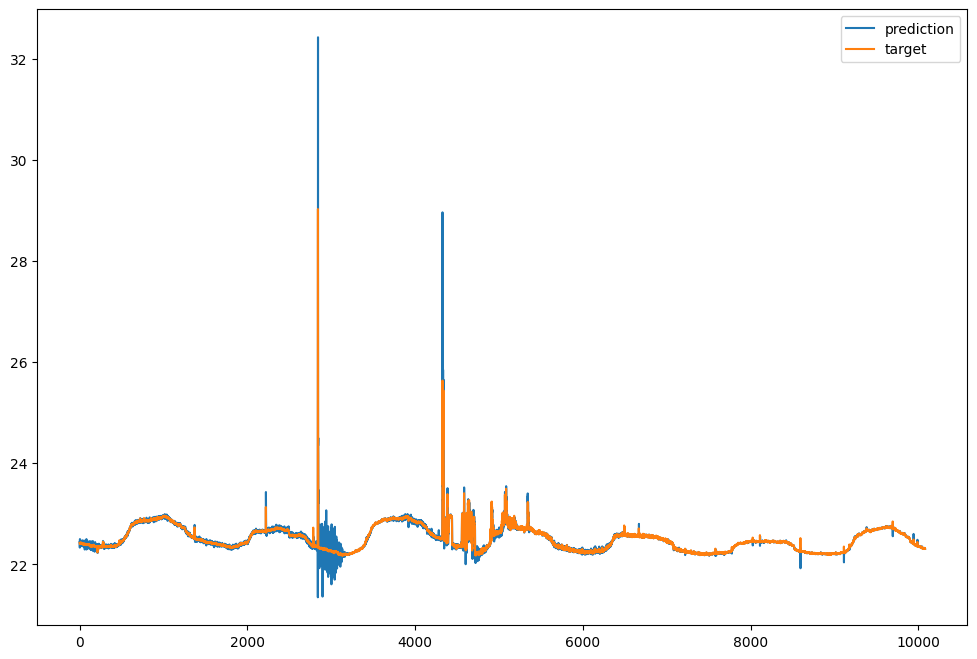

In [16]:
target=list(target.values.reshape(-1))

fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

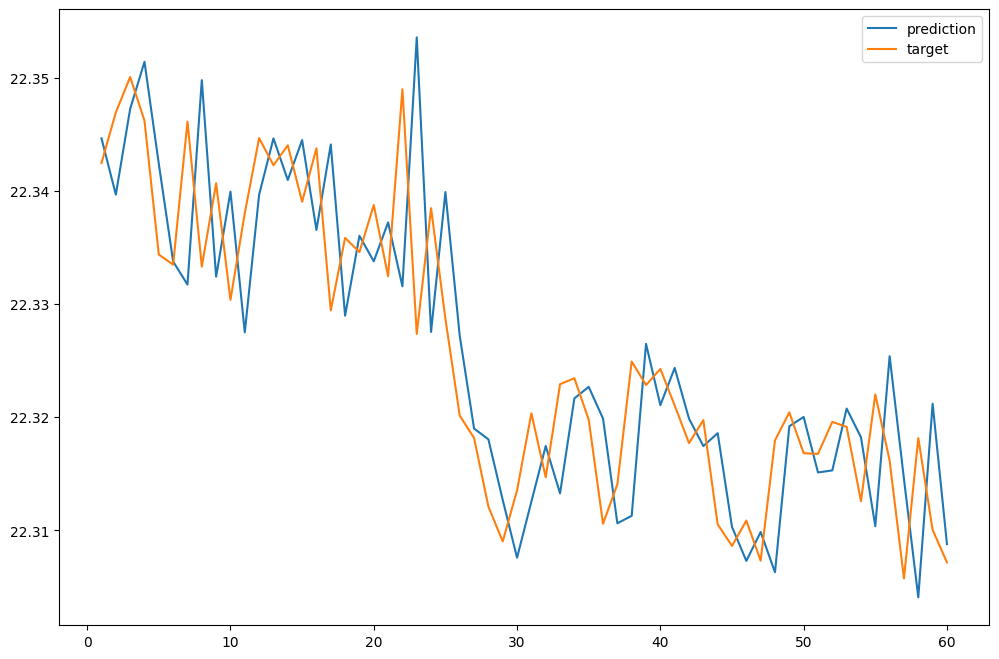

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [21]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                      FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')

SMAPE 0.1254167058505118 %
RMSE 0.12591299414634705
MAPE 0.12574431020766497 %


<font color = blue><font size = 5>결과</font></font><br>
Small Kernel이면 계절성의 다양성이 줄어들어 Kernel을 하나 썼을때와 결과가 비슷하게 나온다